## Demand Forecasting - Data Cleaning, Exploration, Model Selection, Validation, and Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
from scipy.stats import normaltest
from pmdarima import auto_arima
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.express as px
import plotly.graph_objects as go
import pmdarima as pm
from sqlalchemy import create_engine, MetaData, Table, select, and_
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
import datetime
import warnings

# Additional settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")  # specify to ignore warning messages
%matplotlib inline

In [2]:
# Define the SQL Server connection parameters
server = 'airborneanalytics.cpdhuvhrm3nv.us-east-1.rds.amazonaws.com'
database = 'airborneanalytics'  
username = 'Hidden'
password = 'Hidden'

connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"

engine = create_engine(connection_string)

In [7]:
def get_airport_traffic_data(user_origin, sample_data=False):
    """
    Retrieve airport traffic data.

    Parameters:
    - user_origin: Airport code or 'ALL'
    - sample_data: Use sample data (True) or live data (False)

    Returns:
    - daily_ap_cnt_df: DataFrame containing airport traffic data
    """
    if sample_data:
        # Load sample data and filter for a specific period
        daily_ap_cnt_df = pd.read_csv("daily_ap_cnt_df.csv").drop(columns=['Unnamed: 0'])
        daily_ap_cnt_df = daily_ap_cnt_df[(daily_ap_cnt_df['FlightDate'] <= '2019-12-31')]
        return daily_ap_cnt_df
    
    # Define the view and table names
    airport_traffic_table_name = 'Airport_Traffic_2'
    holidays_table_name = 'US_Holidays'

    # Create a connection
    connection = engine.connect()

    # Reflect the view and table structures
    metadata = MetaData()
    airport_traffic_table = Table(airport_traffic_table_name, metadata, autoload=True, autoload_with=engine)
    holidays_table = Table(holidays_table_name, metadata, autoload=True, autoload_with=engine)

    # Build a select query to return all columns from both tables with the join condition
    select_query = select([airport_traffic_table, holidays_table]).select_from(
        airport_traffic_table.outerjoin(holidays_table, and_(
            airport_traffic_table.c.FlightDate == holidays_table.c.Date,
            airport_traffic_table.c.FlightDate <= '2019-12-31'
        ))
    )
    
    # Check if user_origin is not 'ALL', then add the 'Airport' filter
    if user_origin != 'ALL':
        select_query = select_query.where(airport_traffic_table.c.Airport == user_origin)

    # Execute the query and fetch all rows into a Pandas DataFrame
    daily_ap_cnt_df = pd.read_sql_query(select_query, connection)

    # Close the connection
    connection.close()

    return daily_ap_cnt_df

def feature_engineering(df):
    """
    Perform feature engineering on the input DataFrame.

    Parameters:
    - df: DataFrame containing raw data

    Returns:
    - df: DataFrame with additional features
    """
    # Ensure 'FlightDate' is in datetime format
    df['FlightDate'] = pd.to_datetime(df['FlightDate'])
    
    # Set 'FlightDate' as the index and sort by date
    df = df.set_index('FlightDate').drop(columns=['Date'])
    df = df.sort_values(by='FlightDate', ascending=True)

    # Extract features
    df['Month'] = df.index.month
    df['DayOfWeek'] = df.index.dayofweek
    df['weekofyear'] = df.index.isocalendar().week
    df['holiday_bool'] = pd.notnull(df['Holiday']).astype(int)
    
    # Uncomment the line below if you want to one-hot encode the categorical variables
    # df = pd.get_dummies(df, columns=['Month', 'Holiday', 'DayOfWeek', 'weekofyear'], prefix=['Month', 'Holiday', 'DayOfWeek', 'weekofyear'], dtype=int)
    
    # Uncomment the line below if you want to convert the dataframe to integer type
    # df = df.astype(int)

    return df

def plot_daily_flight_trend(df, columns, ap_code):
    """
    Plot daily flight trends.

    Parameters:
    - df: DataFrame containing flight data
    - columns: Columns to plot
    - ap_code: Airport code
    """
    fig = px.line(df, x=df.index, y=columns, title=f"Daily Inbound/Outbound Traffic at {ap_code}", template='seaborn')

    # Customize the layout
    fig.update_xaxes(title_text='Flight Date', tickangle=45, tickformat="%b %Y", dtick="M1")
    fig.update_yaxes(title_text='Flight Count')
    fig.update_layout(title_x=0.5, height=600, width=1000, legend_title_text='')

    # Display the legend in the top left corner
    fig.update_layout(legend=dict(x=0, y=1, traceorder='normal', orientation='h'))

    fig.show()

def create_box_plot(dataframe, x_column):
    """
    Create a box plot for total airport traffic.

    Parameters:
    - dataframe: DataFrame containing data
    - x_column: Column for the x-axis
    """
    fig = px.box(dataframe, x=x_column, y='Total_AirTraffic_count', title=f'Total Airport Traffic by {x_column}', template='seaborn')

    # Customize axis labels
    fig.update_xaxes(title_text=x_column)
    fig.update_yaxes(title_text='Flight Count')

    # Center the title above the plot
    fig.update_layout(title_x=0.5)

    # Show the plot
    fig.show()    
    
def decompose_series(pd_series):
    """
    Decompose a time series into trend, seasonal, and residual components.

    Parameters:
    - pd_series: Pandas Series representing a time series
    """
    # Ensure the index is in datetime format
    pd_series.index = pd.to_datetime(pd_series.index)

    # Decompose the series into monthly segments
    decomp = sm.tsa.seasonal_decompose(pd_series)

    # Create subplots for original, trend, seasonal, and residual components
    fig, axes = plt.subplots(4, 1, figsize=(9, 9), sharex=True)

    # Plot the original time series
    axes[0].plot(pd_series)
    axes[0].set_title('Original Time Series')

    # Plot the trend
    axes[1].plot(decomp.trend)
    axes[1].set_title('Trend')

    # Plot the seasonal component
    axes[2].plot(decomp.seasonal)
    axes[2].set_title('Seasonal Component')

    # Plot the residual
    axes[3].plot(decomp.resid)
    axes[3].set_title('Residual')

    # Set x-axis limits based on the data
    start_date = pd_series.index.min()
    end_date = pd_series.index.max()
    axes[3].set_xlim(start_date, end_date)

    # Set x-axis labels for all months with rotation
    axes[3].xaxis.set_major_locator(mdates.MonthLocator())
    axes[3].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(axes[3].xaxis.get_majorticklabels(), rotation=45, ha="right")

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()
    
def test_stationarity(timeseries, window=12, cutoff=0.01):
    """
    Test the stationarity of a time series.

    Parameters:
    - timeseries: Pandas Series representing a time series
    - window: Rolling window size for mean and standard deviation
    - cutoff: P-value threshold for the ADF test

    Outputs:
    - Displays plots and results of the stationarity test
    """
    
    # Determining rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    # Create traces for Plotly
    trace_original = go.Scatter(x=timeseries.index, y=timeseries, mode='lines', name='Original', line=dict(color='blue'))
    trace_mean = go.Scatter(x=rolmean.index, y=rolmean, mode='lines', name='Rolling Mean', line=dict(color='red'))
    trace_std = go.Scatter(x=rolstd.index, y=rolstd, mode='lines', name='Rolling Std', line=dict(color='black'))

    # Create layout
    layout = go.Layout(
        title='Rolling Mean & Standard Deviation',
        xaxis=dict(title='Date'),
        yaxis=dict(title='Value'),
        showlegend=True,
        title_x=0.5,  # Center the title
        title_y=0.9   # Adjust the y-coordinate as needed
    )

    # Create figure
    fig = go.Figure(data=[trace_original, trace_mean, trace_std], layout=layout)

    # Show the plot
    fig.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    adftest = adfuller(timeseries, autolag='AIC', regression='ct')
    print("Null Hypothesis: The series has a unit root (non-stationary)")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])
    print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

def plot_residual_analysis(model):
    """
    Plot residual analysis for a time series model.

    Parameters:
    - model: Time series model object
    """
    # Get residuals from the model and convert to NumPy array
    resid = np.array(model.resid)

    # Perform normality test
    normal_test_result = normaltest(resid)
    print(f"Normality Test: Chi-squared={normal_test_result.statistic}, p-value={normal_test_result.pvalue}")

    # Plot Residual Distribution
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 12))
    
    # Plot Residual Distribution
    sns.distplot(resid, fit=stats.norm, ax=ax0)
    (mu, sigma) = stats.norm.fit(resid)
    ax0.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    ax0.set_ylabel('Frequency')
    ax0.set_title('Residual Distribution')

    # Plot ACF
    sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax1)
    ax1.set_title('Autocorrelation Function (ACF)')

    # Plot PACF
    sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)
    ax2.set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()

    
def calculate_first_difference(df, column):
    """
    Calculate the first difference of a column in a DataFrame.

    Parameters:
    - df: DataFrame
    - column: Name of the column for which to calculate the first difference

    Returns:
    - df_diff: DataFrame with the first difference column added
    """
    df_diff = df.copy()
    #df_diff[column] = df[column] - df[column].shift(1)
    df_diff[column] = df[column].diff(periods=1)  
    
    return df_diff
    
def smape_kun(y_true, y_pred):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE).

    Parameters:
    - y_true: True values
    - y_pred: Predicted values

    Returns:
    - mape: Mean Absolute Percentage Error
    - smape: Symmetric Mean Absolute Percentage Error
    """
    mape = np.mean(abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    return mape, smape


def calculate_metrics(results_df, test_col='Test', pred_cols=None):
    """
    Calculate metrics for model evaluation.

    Parameters:
    - results_df: DataFrame containing model predictions and true values
    - test_col: Column name for true values
    - pred_cols: List of column names for predicted values

    Returns:
    - metrics_df: DataFrame with MAPE and SMAPE for each model
    """
    if pred_cols is None:
        pred_cols = results_df.columns.difference([test_col])

    metrics_df = pd.DataFrame(index=['MAPE', 'SMAPE'])

    for model_col in pred_cols:
        y_true = results_df[test_col]
        y_pred = results_df[model_col]

        # Drop rows with NaN values
        non_nan_mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
        y_true = y_true[non_nan_mask]
        y_pred = y_pred[non_nan_mask]

        # Calculate metrics
        mape = np.mean(abs((y_true - y_pred) / y_true)) * 100
        smape = np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))).fillna(0))

        metrics_df[model_col] = [mape, smape]

    return metrics_df


In [8]:
# Retrieve sample airport traffic data for all airports
ap_cnt_query_df = get_airport_traffic_data('ALL', sample_data=True)

# Perform feature engineering on the sample data
daily_ap_cnt_df = feature_engineering(ap_cnt_query_df)

# Display the first few rows of the processed DataFrame
daily_ap_cnt_df.head()

Airport  Origin_AirTraffic_count  Dest_AirTraffic_count  \
FlightDate                                                           
2018-01-01     DTW                      322                    320   
2018-01-02     DTW                      413                    419   
2018-01-03     DTW                      407                    403   
2018-01-04     DTW                      406                    405   
2018-01-05     DTW                      410                    408   

            Total_AirTraffic_count         Holiday  Month  DayOfWeek  \
FlightDate                                                             
2018-01-01                     642  New Year's Day      1          0   
2018-01-02                     832             NaN      1          1   
2018-01-03                     810             NaN      1          2   
2018-01-04                     811             NaN      1          3   
2018-01-05                     818             NaN      1          4   

            weekofyear  holiday_bool  
FlightDate                            
2018-01-01           1             1  
2018-01-02           1             0  
2018-01-03           1             0  
2018-01-04           1             0  
2018-01-05           1             0

In [9]:
# Select a specific airport for analysis
airport_selection = 'DTW'
daily_ap_cnt_df_filtered = daily_ap_cnt_df[(daily_ap_cnt_df['Airport'] == airport_selection) & (daily_ap_cnt_df.index <= '2019-12-31')]

In [10]:
daily_ap_cnt_df_filtered

Airport  Origin_AirTraffic_count  Dest_AirTraffic_count  \
FlightDate                                                           
2018-01-01     DTW                      322                    320   
2018-01-02     DTW                      413                    419   
2018-01-03     DTW                      407                    403   
2018-01-04     DTW                      406                    405   
2018-01-05     DTW                      410                    408   
...            ...                      ...                    ...   
2019-12-27     DTW                      453                    453   
2019-12-28     DTW                      410                    410   
2019-12-29     DTW                      446                    447   
2019-12-30     DTW                      454                    453   
2019-12-31     DTW                      313                    315   

            Total_AirTraffic_count         Holiday  Month  DayOfWeek  \
FlightDate                                                             
2018-01-01                     642  New Year's Day      1          0   
2018-01-02                     832             NaN      1          1   
2018-01-03                     810             NaN      1          2   
2018-01-04                     811             NaN      1          3   
2018-01-05                     818             NaN      1          4   
...                            ...             ...    ...        ...   
2019-12-27                     906             NaN     12          4   
2019-12-28                     820             NaN     12          5   
2019-12-29                     893             NaN     12          6   
2019-12-30                     907             NaN     12          0   
2019-12-31                     628  New Year's Eve     12          1   

            weekofyear  holiday_bool  
FlightDate                            
2018-01-01           1             1  
2018-01-02           1             0  
2018-01-03           1             0  
2018-01-04           1             0  
2018-01-05           1             0  
...                ...           ...  
2019-12-27          52             0  
2019-12-28          52             0  
2019-12-29          52             0  
2019-12-30           1             0  
2019-12-31           1             1  

[730 rows x 9 columns]

## Inbound/Outbound Demand Trends

In [11]:
# Define the columns to plot
columns_to_plot = ['Total_AirTraffic_count', 'Origin_AirTraffic_count', 'Dest_AirTraffic_count']

# Plot the daily flight trends for selected columns and airport
plot_daily_flight_trend(daily_ap_cnt_df_filtered, columns_to_plot, airport_selection)

## Demand by Day/Week/Month

In [13]:
create_box_plot(daily_ap_cnt_df_filtered, 'DayOfWeek')
#create_box_plot(daily_ap_cnt_df_filtered, 'DayofMonth')
create_box_plot(daily_ap_cnt_df_filtered, 'weekofyear')

## Decomposition Plot

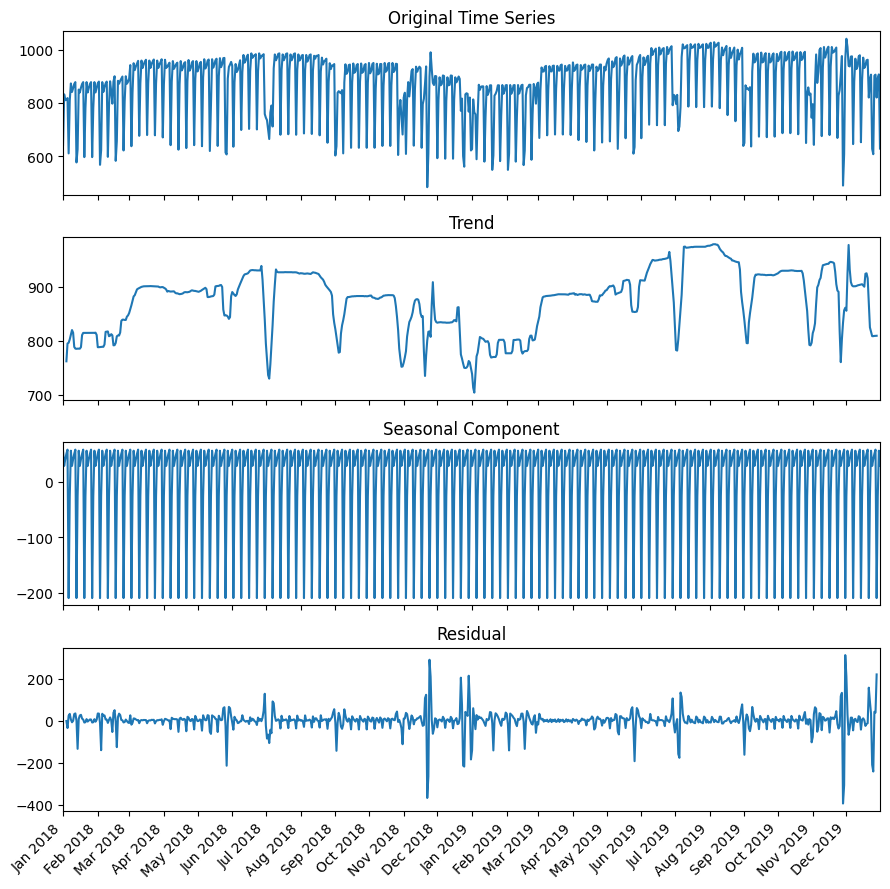

In [14]:
# Decomp and plot
decompose_series(daily_ap_cnt_df_filtered['Total_AirTraffic_count'])

## Test for Stationarity 

In [15]:
daily_ap_cnt_df_filtered = pd.get_dummies(daily_ap_cnt_df_filtered, columns = ['Month','Holiday','DayOfWeek','weekofyear'] , prefix = ['Month','Holiday','DayOfWeek','weekofyear'], dtype=int)
test_stationarity(daily_ap_cnt_df_filtered['Total_AirTraffic_count'])

Results of Dickey-Fuller Test:
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.6495726813210214
P-Value: 0.2576105666695362
Number of lags: 20
Number of observations: 709
Critical Values: {'1%': -3.9715957585172452, '5%': -3.4167004865653943, '10%': -3.1307046974434787}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


### Apply differencing to ensure Total_AirTraffic_count is stationary

In [16]:
first_diff_df = calculate_first_difference(daily_ap_cnt_df_filtered, 'Total_AirTraffic_count')
first_diff_series = first_diff_df['Total_AirTraffic_count'].dropna(inplace = False)
test_stationarity(first_diff_series, window = 12)

Results of Dickey-Fuller Test:
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -8.678465539174628
P-Value: 1.9552948708891452e-12
Number of lags: 20
Number of observations: 708
Critical Values: {'1%': -3.9716139550505587, '5%': -3.416709284224621, '10%': -3.130709870667292}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


After differencing, the p-value is extremely small. Thus this series is very likely to be stationary.

## ACF and PACF

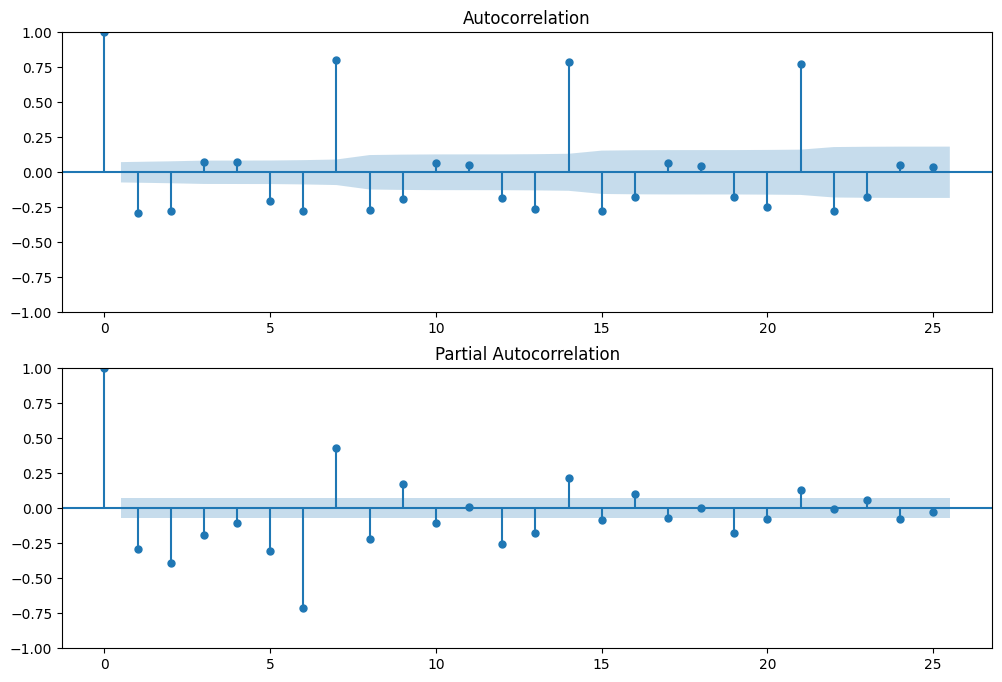

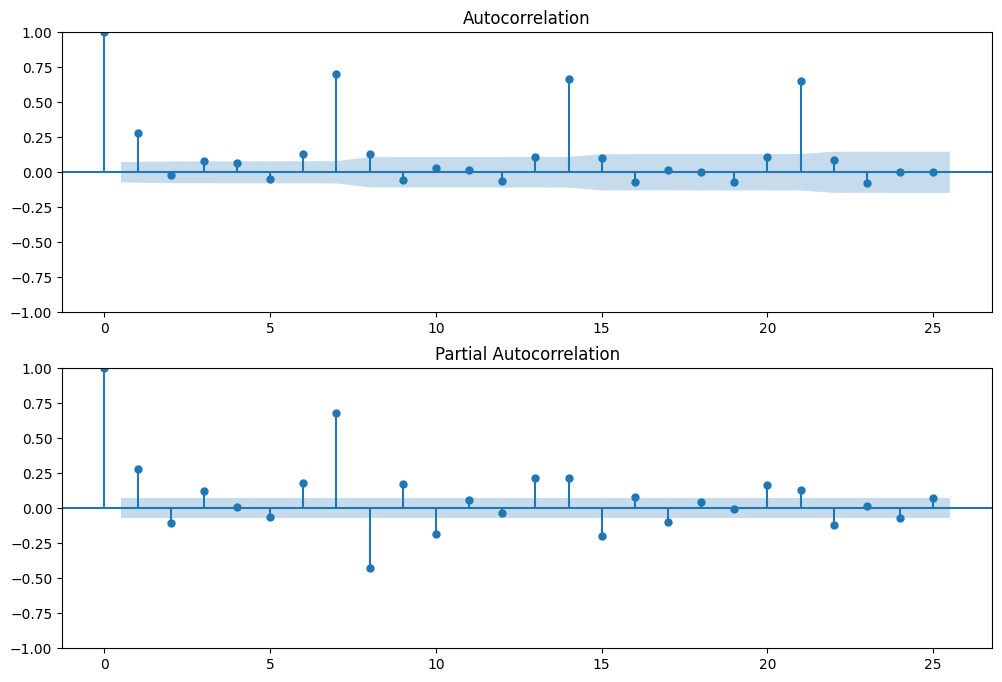

In [17]:
def ACF_PACF_Plot(series, lags):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series, lags=lags, ax=ax1) 
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, lags=lags, ax=ax2)
    

ACF_PACF_Plot(first_diff_series, 25) #uncomment to view plot for differenced series
ACF_PACF_Plot(daily_ap_cnt_df_filtered['Total_AirTraffic_count'], 25)

# Modeling

## ARIMA (Autoregressive integrated moving average)

### Determine p, d, and q values based on ACF/PACF plots

In [18]:
arima_mod = sm.tsa.ARIMA(first_diff_series, order=(3, 1, 1)).fit()
print(arima_mod.summary())

                                 SARIMAX Results                                  
Dep. Variable:     Total_AirTraffic_count   No. Observations:                  729
Model:                     ARIMA(3, 1, 1)   Log Likelihood               -4545.347
Date:                    Tue, 05 Dec 2023   AIC                           9100.694
Time:                            11:14:26   BIC                           9123.646
Sample:                        01-02-2018   HQIC                          9109.550
                             - 12-31-2019                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4822      0.052     -9.302      0.000      -0.584      -0.381
ar.L2         -0.4755      0.054     -8.844      0.000      -0.581      -0.370
ar.L3         -0.196

## Analyze the result
To see how our first model perform, we can plot the residual distribution. Our very low Pvalue suggests that the residuals do not follow a normal distribution. Deviations from normality may indicate that the model is missing some important features or that the underlying data has non-Gaussian characteristics.

ACF and PACF plots help assess whether there is any autocorrelation or remaining structure in the residuals. If significant autocorrelation is present at certain lags, it may indicate that the model has not captured all the temporal patterns.

Normality Test: Chi-squared=188.66674447253126, p-value=1.0753181556000887e-41


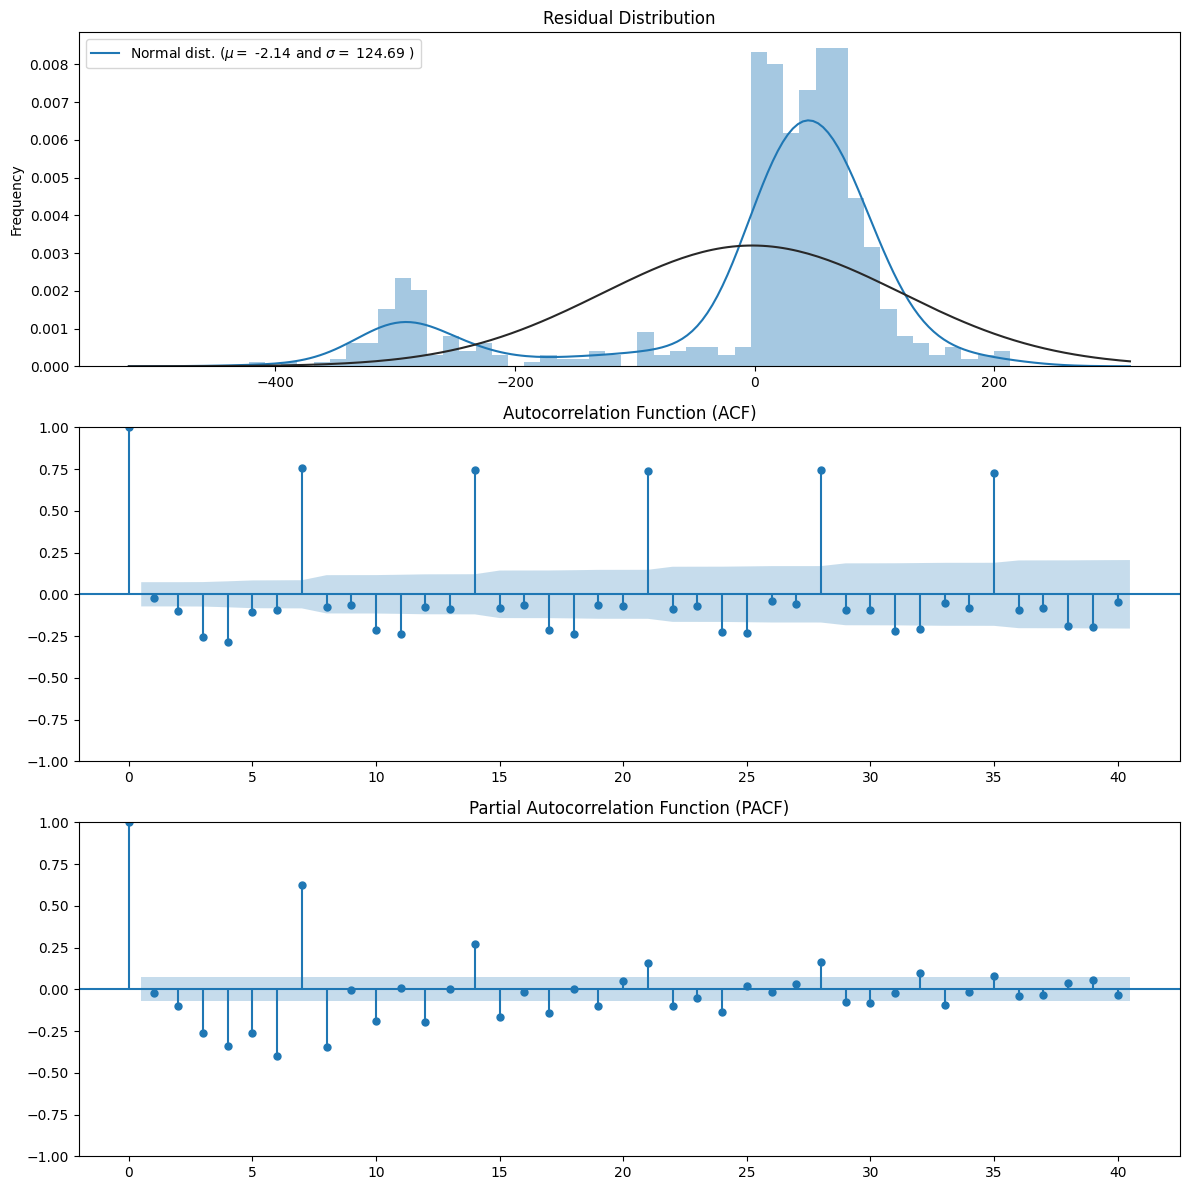

In [19]:
plot_residual_analysis(arima_mod)

## Auto ARIMA

Since our residuals do not follow a normal distribution, we will attempt to use Auto ARIMA to find the optimal p, d, and q values

In [20]:
# Use auto_arima to find the optimal ARIMA parameters
auto_arima_model = auto_arima(daily_ap_cnt_df_filtered['Total_AirTraffic_count'], seasonal=True, suppress_warnings=True, stepwise=True)

# Extract the optimal order
order = auto_arima_model.order

# Fit the ARIMA model with the optimal order
arima_model_auto = sm.tsa.ARIMA(daily_ap_cnt_df_filtered['Total_AirTraffic_count'], order=order).fit()

print(arima_model_auto.summary())

                                 SARIMAX Results                                  
Dep. Variable:     Total_AirTraffic_count   No. Observations:                  730
Model:                     ARIMA(5, 1, 4)   Log Likelihood               -4321.753
Date:                    Tue, 05 Dec 2023   AIC                           8663.506
Time:                            11:15:23   BIC                           8709.422
Sample:                        01-01-2018   HQIC                          8681.222
                             - 12-31-2019                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1998      0.054      3.715      0.000       0.094       0.305
ar.L2         -0.9644      0.043    -22.331      0.000      -1.049      -0.880
ar.L3         -0.059

Normality Test: Chi-squared=170.3100847655441, p-value=1.041441757083328e-37


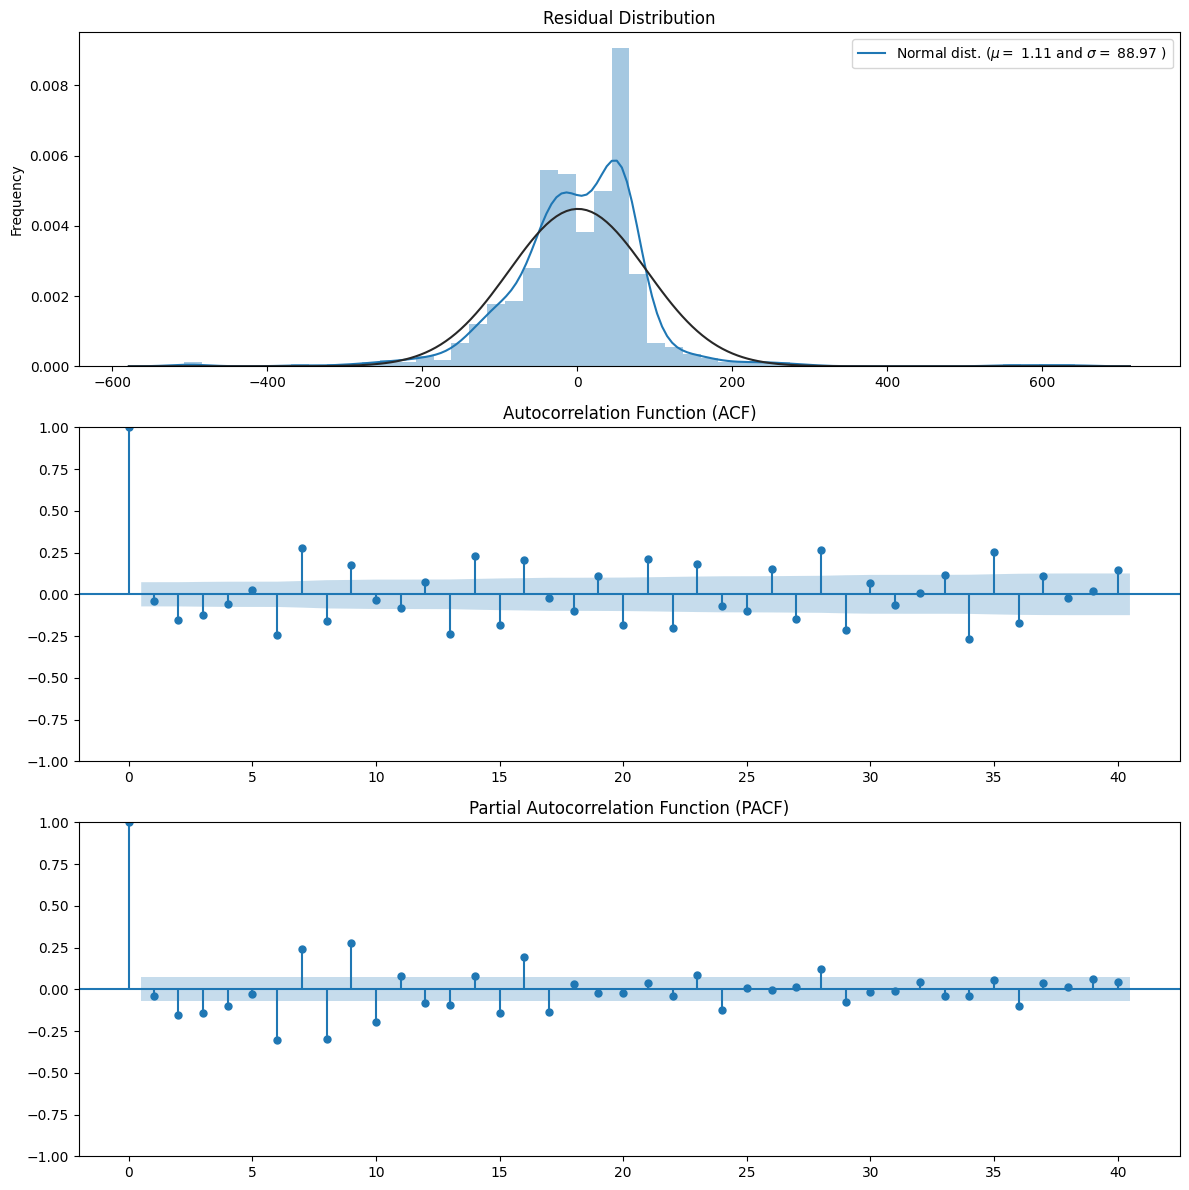

In [21]:
plot_residual_analysis(arima_model_auto)

## Consider seasonality affect by SARIMA

In [24]:
sarima_mod = sm.tsa.statespace.SARIMAX(first_diff_series,order=(5, 1, 4),seasonal_order=(5, 1, 4, 12),
                                       enforce_invertibility=False,enforce_stationarity=False, trend='n')
sarima_results = sarima_mod.fit()
print(sarima_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:             Total_AirTraffic_count   No. Observations:                  729
Model:             SARIMAX(5, 1, 4)x(5, 1, 4, 12)   Log Likelihood               -4051.335
Date:                            Tue, 05 Dec 2023   AIC                           8140.670
Time:                                    11:44:09   BIC                           8225.762
Sample:                                01-02-2018   HQIC                          8173.673
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7871      3.786     -0.208      0.835      -8.208       6.634
ar.L2         -1.4560      1.628   

Normality Test: Chi-squared=81.63656135287913, p-value=1.8743295037205634e-18


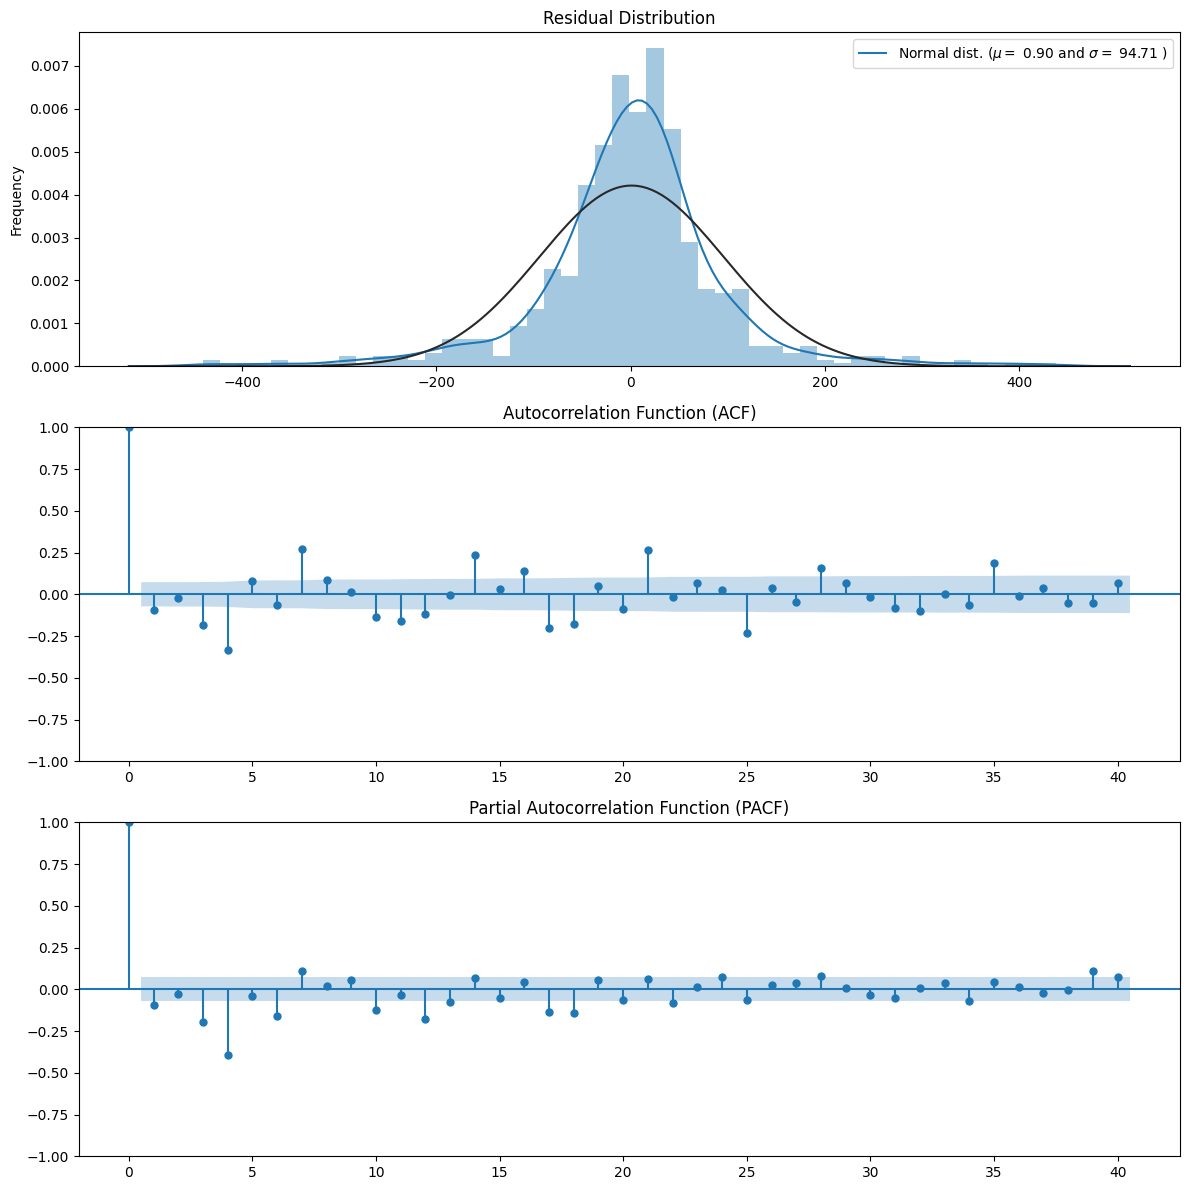

In [25]:
plot_residual_analysis(sarima_results)

## Time series prediction and results analysis

In [26]:
def forecast_and_create_df(train, test, train_orig, test_orig, is_original_series=True):
    """
    Forecast using ARIMA, Auto ARIMA, and SARIMA models and return a DataFrame with predictions.

    Parameters:
    - train: Training time series
    - test: Test time series
    - is_original_series: Flag indicating if the series is original (True) or differenced (False)

    Returns:
    - results_df: DataFrame with predictions
    """

    # Combine train and test for simplicity
    combined_series = pd.concat([train_orig['Total_AirTraffic_count'], test_orig['Total_AirTraffic_count']])

    # Initialize results_df with the combined series
    results_df = pd.DataFrame(combined_series, columns=['Total_AirTraffic_count'])
    exog_train = train.drop(columns=['Airport','Origin_AirTraffic_count','Dest_AirTraffic_count','Total_AirTraffic_count'])
    exog_test = test.drop(columns=['Airport','Origin_AirTraffic_count','Dest_AirTraffic_count','Total_AirTraffic_count'])
    
    if is_original_series:
        d = 0
    else:
        d = 1
        
    # Fit ARIMA(3, 1, 1) model on the training data
    arima_711 = ARIMA(train['Total_AirTraffic_count'], order=(3, d, 1)).fit()

    # Fit Auto ARIMA model on the training data
    auto_arima = pm.auto_arima(train['Total_AirTraffic_count'], seasonal=True, m=12, stepwise=True, suppress_warnings=True)
    auto_arima_order = auto_arima.order
    auto_arima_order_seasonal = auto_arima_order + (12,)
    # Fit SARIMA model on the training data
    sarima_503_12 = sm.tsa.statespace.SARIMAX(train['Total_AirTraffic_count'], order=auto_arima_order, seasonal_order=auto_arima_order_seasonal,
                                             enforce_invertibility=False, enforce_stationarity=False, trend='n').fit()
    if is_original_series:
        sarimax_exog_order = (5,0,3)
    else:
        sarimax_exog_order = (5,0,3)
    # Fit the SARIMAX(5, 0, 3) model with exogenous variables
    print(sarimax_exog_order)
    sarimax_exog = SARIMAX(
        endog=train['Total_AirTraffic_count'],
        exog=exog_train,
        order=sarimax_exog_order,
        enforce_invertibility=False,
        enforce_stationarity=False,
        trend='n'
    ).fit()
    
    # Make predictions for the forecast period
    y_pred_arima = arima_711.get_forecast(steps=len(test['Total_AirTraffic_count'])).predicted_mean.round().astype(int)
    y_pred_auto_arima = np.round(auto_arima.predict(n_periods=len(test['Total_AirTraffic_count']))).astype(int)
    y_pred_sarima = sarima_503_12.get_forecast(steps=len(test['Total_AirTraffic_count'])).predicted_mean.round().astype(int)
    y_pred_sarimax_exog = sarimax_exog.get_forecast(steps=len(test['Total_AirTraffic_count']), exog=exog_test).predicted_mean

        
    if not is_original_series:
        y_pred_arima = np.cumsum(y_pred_arima) + test_orig['Total_AirTraffic_count'].iloc[0]
        y_pred_auto_arima = np.cumsum(y_pred_auto_arima) + test_orig['Total_AirTraffic_count'].iloc[0]
        y_pred_sarima = np.cumsum(y_pred_sarima) + test_orig['Total_AirTraffic_count'].iloc[0]
        y_pred_sarimax_exog = np.cumsum(y_pred_sarimax_exog) + test_orig['Total_AirTraffic_count'].iloc[0]

    # Update results_df with predictions
    results_df['ARIMA_Predictions'] = np.nan
    results_df.loc[test.index, 'ARIMA_Predictions'] = y_pred_arima

    results_df['Auto_ARIMA_Predictions'] = np.nan
    results_df.loc[test.index, 'Auto_ARIMA_Predictions'] = y_pred_auto_arima

    results_df['SARIMA_Predictions'] = np.nan
    results_df.loc[test.index, 'SARIMA_Predictions'] = y_pred_sarima
    
    results_df['SARIMAX_exog_Predictions'] = np.nan
    results_df.loc[test_orig.index, 'SARIMAX_exog_Predictions'] = y_pred_sarimax_exog
    
    # Plot the original time series, test set, and predictions
    fig, ax = plt.subplots(2, 1, figsize=(22, 10), sharex=False)

    # Plot 1: Original Time Series, Test Set, and Predictions
    ax[0].plot(results_df.index, results_df['Total_AirTraffic_count'], color='black', label='Original Series', linewidth=2)
    if not is_original_series:
        ax[0].plot(test_orig.index, test_orig['Total_AirTraffic_count'], linestyle='--', color='red', label='Test Set Original')
    else:
        ax[0].plot(test.index, test['Total_AirTraffic_count'], linestyle='--', color='red', label='Test Set Original')
    ax[0].plot(results_df.index, results_df['ARIMA_Predictions'], color='green', label='ARIMA Predictions')
    ax[0].plot(results_df.index, results_df['Auto_ARIMA_Predictions'], color='blue', label='Auto-ARIMA Predictions')
    ax[0].plot(results_df.index, results_df['SARIMA_Predictions'], color='orange', label='SARIMA Predictions')
    ax[0].plot(results_df.index, results_df['SARIMAX_exog_Predictions'], color='purple', label='SARIMA Predictions')
    
    # Set x-axis limits based on the data
    #start_date = results_df.index.min()
    start_date = pd.to_datetime("2018-07-01", format='%Y-%m-%d')
    end_date = results_df.index.max()
    ax[0].set_xlim(start_date, end_date)
    
    ax[0].set_ylabel('Number of Flights')
    ax[0].set_title("Model Comparisons")
    ax[0].legend()

    # Plot 2: Predicted Time Frame Only
    if not is_original_series:
        ax[1].plot(test_orig.index, test_orig['Total_AirTraffic_count'], linestyle='--', color='red', label='Test Set Original', linewidth=3)
    else:
        ax[1].plot(test.index, test['Total_AirTraffic_count'], linestyle='--', color='red', label='Test Set Original', linewidth=3)
    ax[1].plot(results_df.index, results_df['ARIMA_Predictions'], color='green', label='ARIMA Predictions')
    ax[1].plot(results_df.index, results_df['Auto_ARIMA_Predictions'], color='blue', label='Auto-ARIMA Predictions')
    ax[1].plot(results_df.index, results_df['SARIMA_Predictions'], color='orange', label='SARIMA Predictions')
    ax[1].plot(results_df.index, results_df['SARIMAX_exog_Predictions'], color='purple', label='SARIMA Exog Predictions')
    
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Number of Flights')
    ax[1].set_title("Predicted Time Frame")
    ax[1].legend()

    # Set x-axis limits for the second subplot
    ax[1].set_xlim(test.index.min(), test.index.max())

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return results_df


(5, 0, 3)


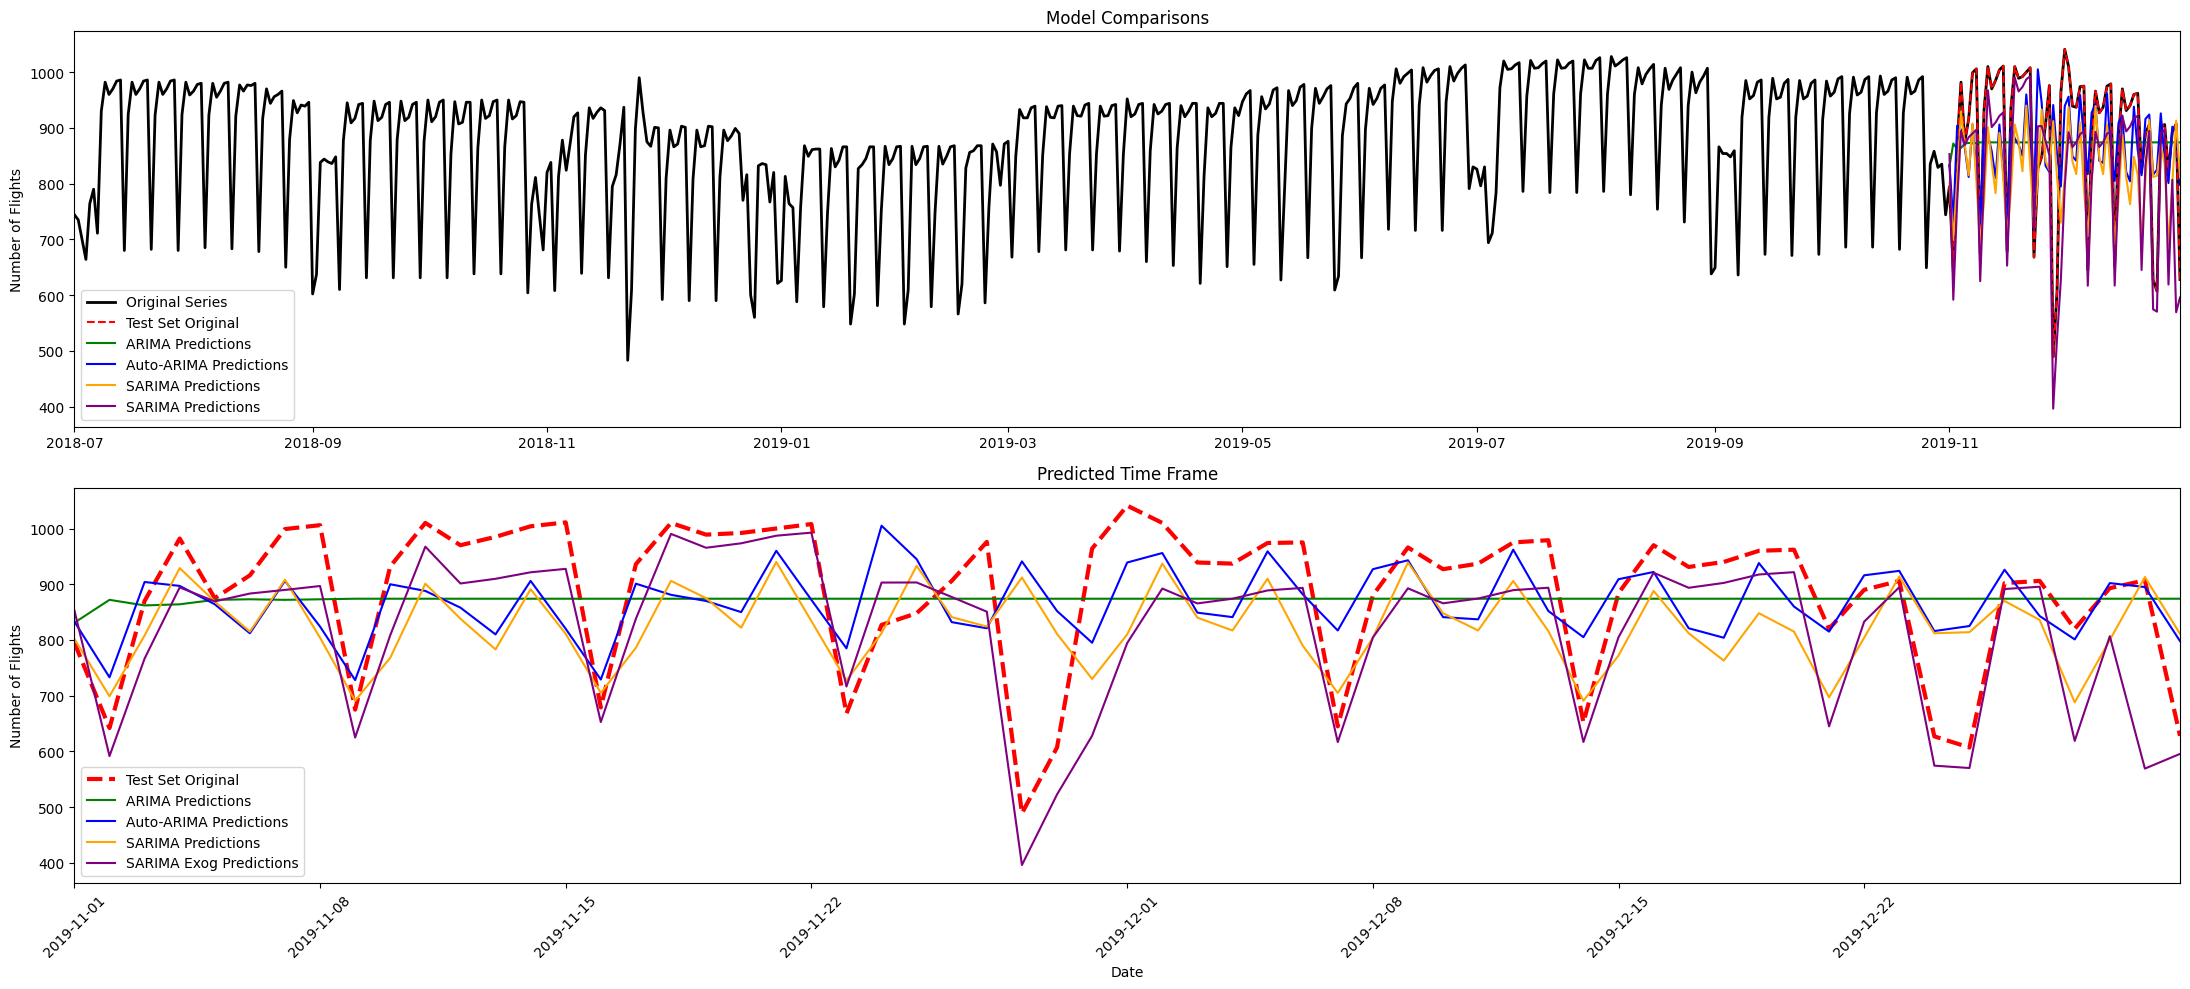

In [27]:
daily_ap_cnt_df_split = daily_ap_cnt_df_filtered

train_orig = daily_ap_cnt_df_split[daily_ap_cnt_df_split.index < pd.to_datetime("2019-11-01", format='%Y-%m-%d')]
test_orig = daily_ap_cnt_df_split[daily_ap_cnt_df_split.index >= pd.to_datetime("2019-11-01", format='%Y-%m-%d')]

# Split the differenced series into training and test sets
train_diff = first_diff_df[first_diff_df.index < pd.to_datetime("2019-11-01")].dropna(inplace = False)
test_diff = first_diff_df[first_diff_df.index >= pd.to_datetime("2019-11-01")].dropna(inplace = False)

# Create models for original data and plot results
results_orig = forecast_and_create_df(train_orig, test_orig, train_orig, test_orig, is_original_series=True)

(5, 0, 3)


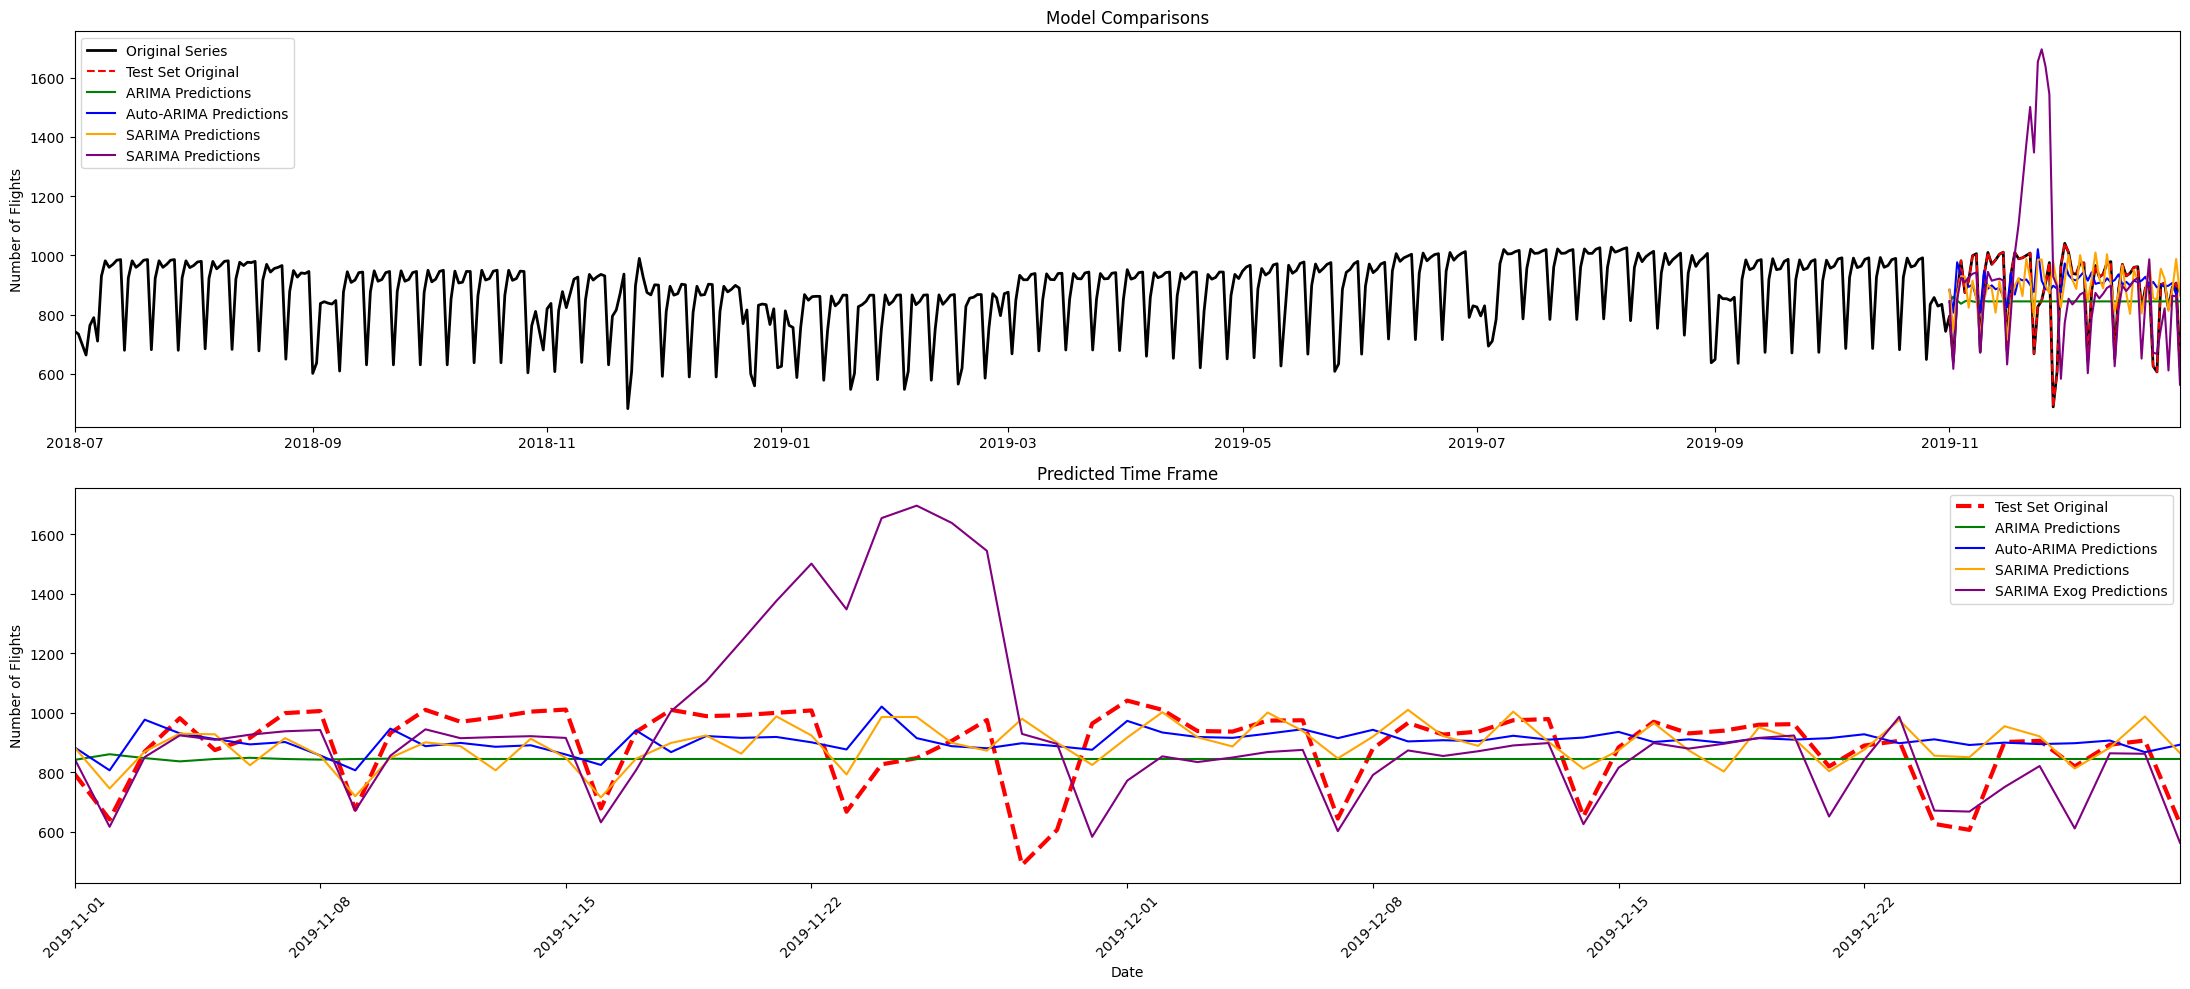

In [28]:
# Create models for differenced data and plot results
results_diff = forecast_and_create_df(train_diff, test_diff, train_orig, test_orig, is_original_series=False)

In [29]:
# Model results comparison for original data
model_results_comparison_orig = calculate_metrics(results_orig, test_col='Total_AirTraffic_count', pred_cols=None)
model_results_comparison_orig

ARIMA_Predictions  Auto_ARIMA_Predictions  SARIMAX_exog_Predictions  \
MAPE           13.733473               12.187771                  8.603332   
SMAPE          12.776799               11.583008                  9.268125   

       SARIMA_Predictions  
MAPE            13.368576  
SMAPE           13.338992

In [30]:
# Model results comparison for differenced data
model_results_comparison_diff = calculate_metrics(results_diff, test_col='Total_AirTraffic_count', pred_cols=None)
model_results_comparison_diff

ARIMA_Predictions  Auto_ARIMA_Predictions  SARIMAX_exog_Predictions  \
MAPE           14.946106               12.827291                 18.741870   
SMAPE          14.462437               11.550313                 16.097013   

       SARIMA_Predictions  
MAPE            11.709806  
SMAPE           10.699226

## XGBOOST

In [31]:
features = [ 'holiday_bool',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'Holiday_4th of July', 'Holiday_Christmas Day','Holiday_Christmas Eve','Holiday_Columbus Day',
        'Holiday_Eastern Easter','Holiday_Juneteenth', 'Holiday_Labor Day','Holiday_Labor Day Weekend', 
        'Holiday_Martin Luther King, Jr. Day','Holiday_Memorial Day',"Holiday_New Year's Day","Holiday_New Year's Eve",
        'Holiday_Thanksgiving Day','Holiday_Thanksgiving Eve',"Holiday_Valentine's Day",'Holiday_Veterans Day',
         "Holiday_Washington's Birthday",'Holiday_Western Easter', 'DayOfWeek_0',
       'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5',
       'DayOfWeek_6', 'weekofyear_1', 'weekofyear_2', 'weekofyear_3', 'weekofyear_4', 'weekofyear_5', 'weekofyear_6',
        'weekofyear_7', 'weekofyear_8', 'weekofyear_9', 'weekofyear_10', 'weekofyear_11', 'weekofyear_12',
        'weekofyear_13', 'weekofyear_14', 'weekofyear_15', 'weekofyear_16', 'weekofyear_17', 'weekofyear_18',
        'weekofyear_19', 'weekofyear_20', 'weekofyear_21', 'weekofyear_22', 'weekofyear_23', 'weekofyear_24',
        'weekofyear_25', 'weekofyear_26', 'weekofyear_27', 'weekofyear_28', 'weekofyear_29', 'weekofyear_30',
        'weekofyear_31', 'weekofyear_32', 'weekofyear_33', 'weekofyear_34', 'weekofyear_35', 'weekofyear_36',
        'weekofyear_37', 'weekofyear_38', 'weekofyear_39', 'weekofyear_40', 'weekofyear_41', 'weekofyear_42',
        'weekofyear_43', 'weekofyear_44', 'weekofyear_45', 'weekofyear_46', 'weekofyear_47', 'weekofyear_48',
        'weekofyear_49', 'weekofyear_50', 'weekofyear_51', 'weekofyear_52']

In [32]:
X_train = train_orig[features]
y_train = train_orig['Total_AirTraffic_count']

X_test = test_orig[features]
y_test = test_orig['Total_AirTraffic_count']

In [33]:
best_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1500,
                       #early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=2,
                       learning_rate=0.03,
                       n_jobs=-1,tree_method='hist')
best_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:855.12359	validation_1-rmse:868.16557
[100]	validation_0-rmse:73.76627	validation_1-rmse:111.14404
[200]	validation_0-rmse:50.50315	validation_1-rmse:91.71482
[300]	validation_0-rmse:44.94912	validation_1-rmse:90.38057
[400]	validation_0-rmse:41.82458	validation_1-rmse:89.75202
[500]	validation_0-rmse:39.38206	validation_1-rmse:90.21338
[600]	validation_0-rmse:37.99533	validation_1-rmse:90.57905
[700]	validation_0-rmse:36.86766	validation_1-rmse:91.06883
[800]	validation_0-rmse:36.20041	validation_1-rmse:91.25753
[900]	validation_0-rmse:35.51057	validation_1-rmse:91.54557
[1000]	validation_0-rmse:35.00506	validation_1-rmse:91.67583
[1100]	validation_0-rmse:34.49264	validation_1-rmse:91.98362
[1200]	validation_0-rmse:34.10893	validation_1-rmse:91.89410
[1300]	validation_0-rmse:33.72622	validation_1-rmse:91.87891
[1400]	validation_0-rmse:33.29380	validation_1-rmse:91.69393
[1499]	validation_0-rmse:32.84379	validation_1-rmse:91.56259


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=-1,
             num_parallel_tree=None, objective='reg:linear', ...)

In [ ]:
# # Define the parameter grid to search
# param_grid = {
#     'max_depth': [2, 3, 5],
#     'learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'n_estimators': [1000, 1250, 1500, 1750, 2000],
#     'subsample': [0.8, 0.9, 1.0],
# }

# # Create an XGBoost regressor
# reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', objective='reg:linear')

# # Use GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(reg, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
# grid_search.fit(X_train, y_train)

# # Print the best parameters
# print("Best Parameters:", grid_search.best_params_)

# # Get the best model
# best_reg = grid_search.best_estimator_

# # Fit the best model on the entire training set
# best_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

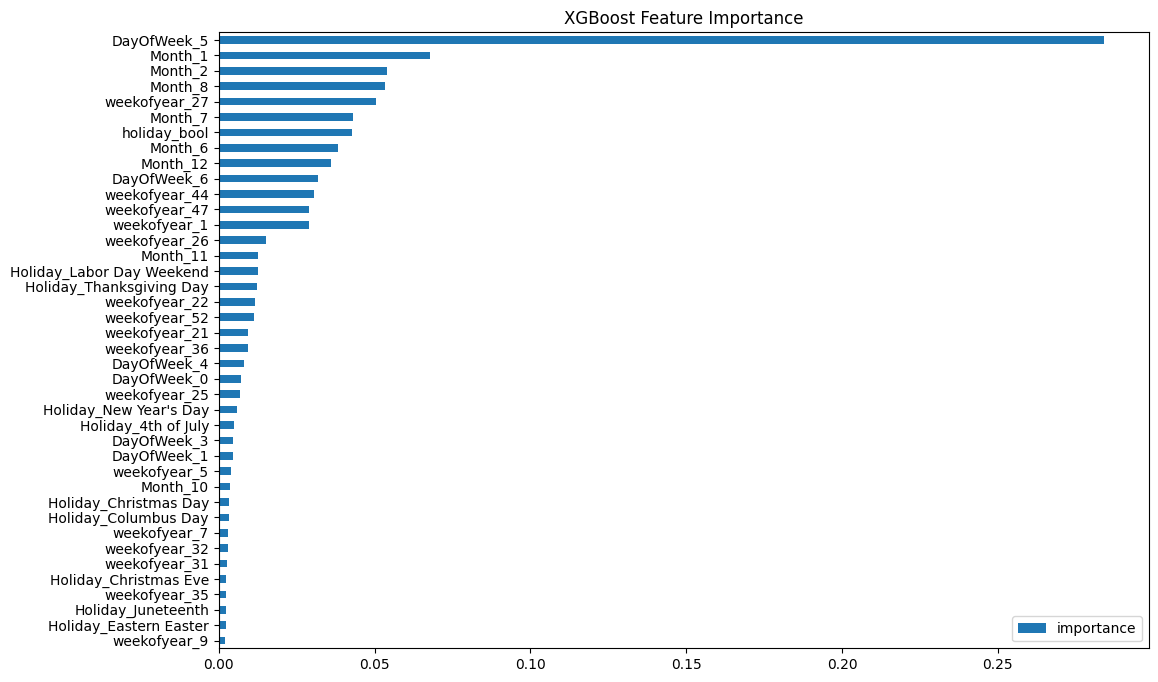

In [34]:
fi = pd.DataFrame(data=best_reg.feature_importances_,
             index=best_reg.feature_names_in_,
             columns=['importance'])

# Sort the DataFrame by importance and select the top 10
top_features = fi.sort_values('importance', ascending=False).head(40)

# Reverse the order to have the most important feature at the top
top_features = top_features[::-1]

# Increase plot size
fig, ax = plt.subplots(figsize=(12, 8))

top_features.plot(kind='barh', title='XGBoost Feature Importance', ax=ax)
plt.show()

In [35]:
test_orig['XGBoost_Predictions'] = best_reg.predict(X_test)
results_orig_final = results_orig.merge(test_orig[['XGBoost_Predictions']], how='left', left_index=True, right_index=True)

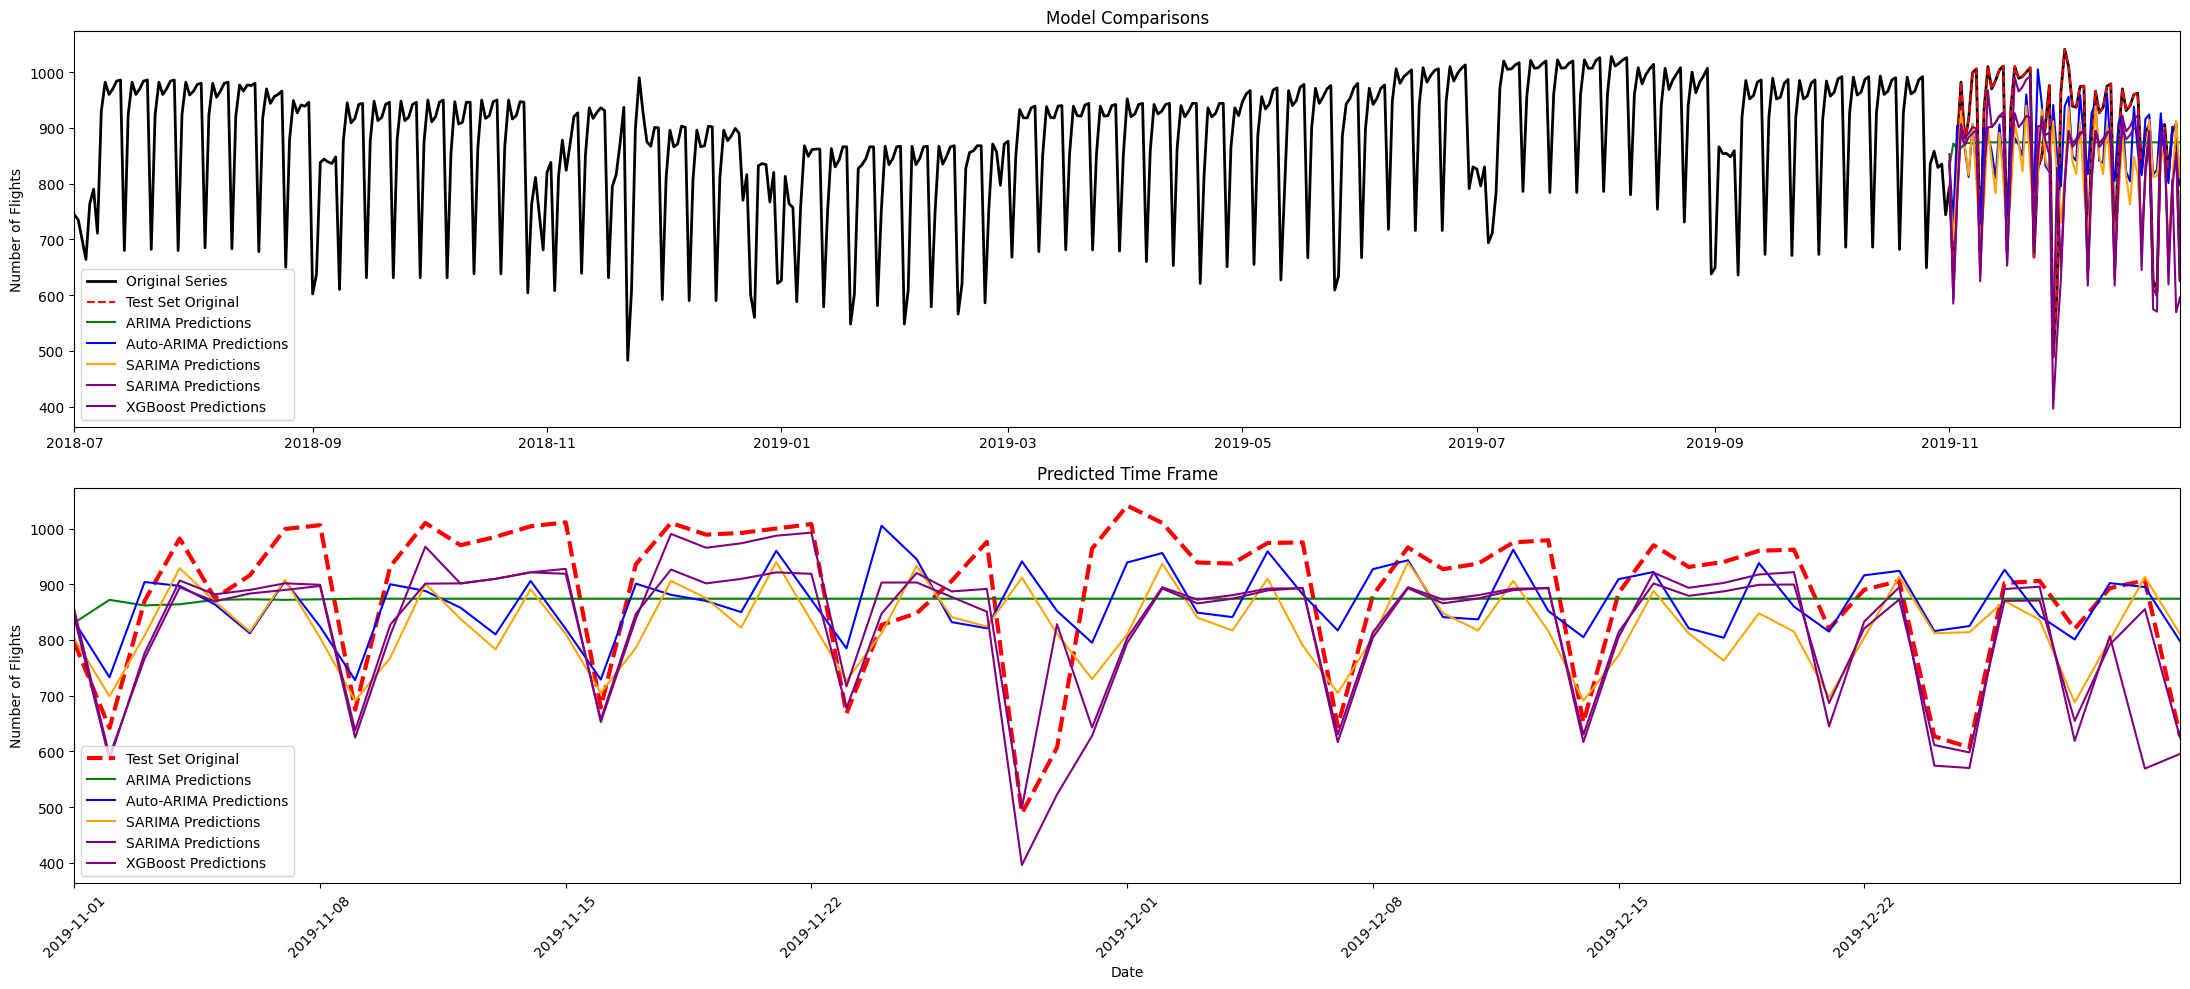

In [36]:
# Plot the original time series, test set, and predictions
fig, ax = plt.subplots(2, 1, figsize=(22, 10), sharex=False)

# Plot 1: Original Time Series, Test Set, and Predictions
ax[0].plot(results_orig_final.index, results_orig_final['Total_AirTraffic_count'], color='black', label='Original Series', linewidth=2)
ax[0].plot(test_orig.index, test_orig['Total_AirTraffic_count'], linestyle='--', color='red', label='Test Set Original')
ax[0].plot(results_orig_final.index, results_orig_final['ARIMA_Predictions'], color='green', label='ARIMA Predictions')
ax[0].plot(results_orig_final.index, results_orig_final['Auto_ARIMA_Predictions'], color='blue', label='Auto-ARIMA Predictions')
ax[0].plot(results_orig_final.index, results_orig_final['SARIMA_Predictions'], color='orange', label='SARIMA Predictions')
ax[0].plot(results_orig_final.index, results_orig_final['SARIMAX_exog_Predictions'], color='purple', label='SARIMA Predictions')
ax[0].plot(results_orig_final.index, results_orig_final['XGBoost_Predictions'], color='purple', label='XGBoost Predictions')

# Set x-axis limits based on the data
#start_date = results_df.index.min()
start_date = pd.to_datetime("2018-07-01", format='%Y-%m-%d')
end_date = results_orig_final.index.max()
ax[0].set_xlim(start_date, end_date)

ax[0].set_ylabel('Number of Flights')
ax[0].set_title("Model Comparisons")
ax[0].legend()

# Plot 2: Predicted Time Frame Only

ax[1].plot(test_orig.index, test_orig['Total_AirTraffic_count'], linestyle='--', color='red', label='Test Set Original', linewidth=3)
ax[1].plot(results_orig_final.index, results_orig_final['ARIMA_Predictions'], color='green', label='ARIMA Predictions')
ax[1].plot(results_orig_final.index, results_orig_final['Auto_ARIMA_Predictions'], color='blue', label='Auto-ARIMA Predictions')
ax[1].plot(results_orig_final.index, results_orig_final['SARIMA_Predictions'], color='orange', label='SARIMA Predictions')
ax[1].plot(results_orig_final.index, results_orig_final['SARIMAX_exog_Predictions'], color='purple', label='SARIMA Predictions')
ax[1].plot(results_orig_final.index, results_orig_final['XGBoost_Predictions'], color='purple', label='XGBoost Predictions')

ax[1].set_xlabel('Date')
ax[1].set_ylabel('Number of Flights')
ax[1].set_title("Predicted Time Frame")
ax[1].legend()

# Set x-axis limits for the second subplot
ax[1].set_xlim(test_orig.index.min(), test_orig.index.max())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
model_results_comparison_orig = calculate_metrics(results_orig_final, test_col='Total_AirTraffic_count', pred_cols=None)
model_results_comparison_orig

ARIMA_Predictions  Auto_ARIMA_Predictions  SARIMAX_exog_Predictions  \
MAPE           13.733473               12.187771                  8.603332   
SMAPE          12.776799               11.583008                  9.268125   

       SARIMA_Predictions  XGBoost_Predictions  
MAPE            13.368576             8.135046  
SMAPE           13.338992             8.489236